In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

from datasets.sequence_folders import SequenceFolder
from utils import tensor2array

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
train_set = SequenceFolder(
            '/mnt/datasets/yasin/range-azimuth',
            train=True,
            sequence_length=3,
            skip_frames=10
        )

In [21]:
train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=8, shuffle=True,
        num_workers=4, pin_memory=True)

In [22]:
dataset_iter = iter(train_loader)
tgt_img, ref_imgs = next(dataset_iter)
tgt_img = tgt_img.to(device)
ref_imgs = [img.to(device) for img in ref_imgs]

In [23]:
print(tgt_img.shape)
print(len(ref_imgs))
print(ref_imgs[0].shape)
print(tgt_img.mean(), tgt_img.std())

torch.Size([8, 1, 256, 64])
2
torch.Size([8, 1, 256, 64])
tensor(119.4313, device='cuda:0') tensor(6.2648, device='cuda:0')


In [24]:
rangeResolutionsInMeter = 0.0977
numRangeBins = 256
num_angle_bins = 64

warper = Warper(rangeResolutionsInMeter, numRangeBins, num_angle_bins, 0)

In [34]:
pose = torch.tensor([0., 0, 0.34, 0.53,0,0]) # rx,ry,rz,x,y,z
print(pose.shape)
pose_batch = pose.repeat(8,1)
print(pose_batch.shape)
pose_batch = pose_batch.to(device)

torch.Size([6])
torch.Size([8, 6])


In [35]:
projected_img, valid_points, theta_tformed, rho_tformed = warper.inverse_warp_fft(ref_imgs[0], pose_batch)

In [36]:
theta_tformed_hw = theta_tformed[0].reshape(64, 256)
print(theta_tformed_hw.shape)
print(theta_tformed_hw)

torch.Size([64, 256])
tensor([[  0.0000,  -1.9396,  -3.3633,  ..., -12.2586, -12.2596, -12.2606],
        [  0.0000,  -1.7859,  -3.0959,  ..., -11.2792, -11.2801, -11.2810],
        [  0.0000,  -1.6320,  -2.8282,  ..., -10.2998, -10.3007, -10.3015],
        ...,
        [  0.0000,   7.0117,  12.5073,  ...,  47.5736,  47.5772,  47.5807],
        [  0.0000,   7.1331,  12.7406,  ...,  48.5595,  48.5631,  48.5666],
        [  0.0000,   7.2531,  12.9723,  ...,  49.5457,  49.5493,  49.5529]],
       device='cuda:0')


In [37]:
rho_tformed_hw = rho_tformed[0].reshape(64, 256)
print(rho_tformed_hw.shape)
print(rho_tformed_hw)

torch.Size([64, 256])
tensor([[ 0.5300,  0.6257,  0.7220,  ..., 25.2358, 25.3335, 25.4311],
        [ 0.5300,  0.6260,  0.7225,  ..., 25.2376, 25.3353, 25.4330],
        [ 0.5300,  0.6263,  0.7230,  ..., 25.2394, 25.3371, 25.4348],
        ...,
        [ 0.5300,  0.5992,  0.6756,  ..., 25.0726, 25.1702, 25.2679],
        [ 0.5300,  0.5981,  0.6735,  ..., 25.0657, 25.1634, 25.2610],
        [ 0.5300,  0.5969,  0.6715,  ..., 25.0587, 25.1564, 25.2541]],
       device='cuda:0')


In [38]:
print(projected_img.shape)

torch.Size([8, 1, 256, 64])


In [44]:
img_tgt = tensor2array(tgt_img[0], colormap='bone')
img_src = tensor2array(projected_img[0], colormap='bone')
img_valid = tensor2array(valid_points[0], colormap='bone', max_value=1)

In [45]:
img_tgt=img_tgt.transpose(1, 2, 0)
img_src=img_src.transpose(1, 2, 0)
img_valid=img_valid.transpose(1, 2, 0)

print(img_tgt.shape)
print(img_src.shape)
print(img_valid.shape)

(256, 64, 4)
(256, 64, 4)
(256, 64, 4)


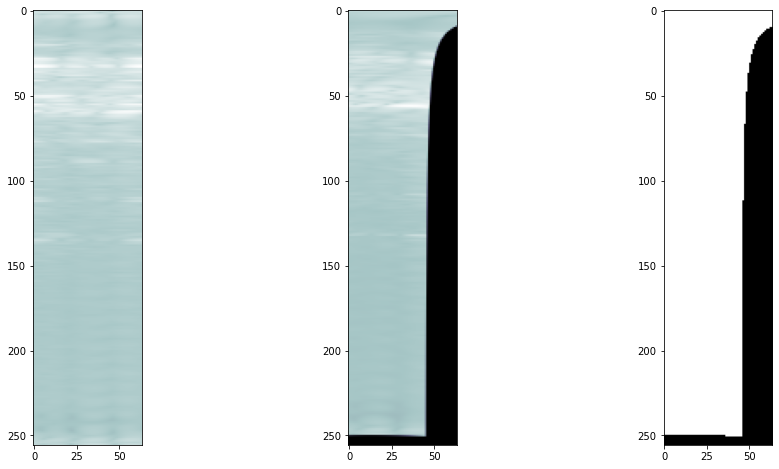

In [46]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(img_tgt)
plt.subplot(132)
plt.imshow(img_src)
plt.subplot(133)
plt.imshow(img_valid)

In [42]:
valid_points.shape

torch.Size([8, 1, 256, 64])

In [4]:
from __future__ import division
import torch
import torch.nn.functional as F

import conversions as tgm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Warper(object):
    """Inverse warper class
    """

    # xy_hom = None

    def __init__(self, rangeResolutionsInMeter, angleResolutionInRad, numRangeBins, num_angle_bins,
    with_auto_mask, padding_mode='zeros'):
        # RF params
        # rangeResolutionsInMeter = 0.0977
        # # dopplerResolutionMps = 0.0951
        # numRangeBins = 256
        # # numDopplerBins = 128
        # num_angle_bins = 64 # our choice
        self.rangeResolutionsInMeter=rangeResolutionsInMeter
        self.angleResolutionInRad = angleResolutionInRad
        self.numRangeBins=numRangeBins
        self.num_angle_bins=num_angle_bins
        self.with_auto_mask=with_auto_mask
        self.padding_mode=padding_mode

        azimuths = torch.arange(num_angle_bins)
        # azimuths = (azimuths - (num_angle_bins / 2))
        azimuths = azimuths*angleResolutionInRad
        ranges = torch.arange(numRangeBins)
        ranges = ranges*rangeResolutionsInMeter

        az_grid, range_grid = torch.meshgrid(azimuths, ranges) # [num_angle_bins, numRangeBins], i.e. [W, H]
        x, y = pol2cart(az_grid, range_grid)
        x=torch.flatten(x)
        y=torch.flatten(y)

        xy = torch.vstack((x, y, torch.zeros_like(x)))  # [3,N] Augment with zero z column
        xy = torch.transpose(xy, 0,1) # [N,3]
        self.xy_hom = tgm.convert_points_to_homogeneous(xy).to(device) # [N,4]

    
    def radar2pixel(self, pose_mat):
        """Transform coordinates in the source frame to the target frame.
        Args:
            cam_coords: pixel coordinates defined in the first camera coordinates system -- [B, 4, H, W]
            proj_c2p_rot: rotation matrix of cameras -- [B, 3, 4]
            proj_c2p_tr: translation vectors of cameras -- [B, 3, 1]
        Returns:
            array of [-1,1] coordinates -- [B, 2, H, W]
        """
        # Transform points
        tformed_xy_hom = torch.matmul(pose_mat, torch.transpose(self.xy_hom, 0,1)) # [B,4,N]
        tformed_xy_hom = torch.transpose(tformed_xy_hom, 1,2) # [B,N,4]
        # Convert from homogenous coordinates
        tformed_xy = tgm.convert_points_from_homogeneous(tformed_xy_hom) # [B,N,3]
        # Convert back from cartesian to polar
        theta_tformed_rad, rho_tformed = cart2pol(tformed_xy[:,:,0], tformed_xy[:,:,1]) # [B,N], [B,N]
        # theta_tformed = torch.rad2deg(theta_tformed_rad) # [B,N]

        # tformed_xy = tformed_xy[:,0:2,:] # Drop augmented z column [B,2,N]
        # Replace 0-valued augmented z column with dB values of source img 
        # tformed_xy[:,2,:] = torch.flatten(img, start_dim=1) # [B,3,N] N points with x,y and db values

        X = theta_tformed_rad #theta_tformed # [B,N]
        Y = rho_tformed # [B,N]
        w = self.num_angle_bins*self.angleResolutionInRad
        h = (self.numRangeBins-1)*self.rangeResolutionsInMeter

        # Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
        X_norm = 2*X/w
        Y_norm = 2*Y/h - 1  # Idem [B, H*W]

        pixel_coords = torch.stack([X_norm, Y_norm], dim=2)  # [B, H*W, 2]
        pixel_coords = pixel_coords.reshape(self.b, self.w, self.h, 2) # [B, W, H, 2]
        pixel_coords = pixel_coords.transpose(1,2) # [B, H, W, 2]

        return pixel_coords, theta_tformed, rho_tformed
    
    def inverse_warp_fft(self, img, pose, rotation_mode='euler'):
        """
        Inverse warp a source radar frame to the target radar plane.
        H: Number of ADC samples (or Doppler bins)
        W: Number of angle bins
        Args:
            img: the source radar frame image (where to sample pixels) -- [B, H, W]
            pose: 6DoF pose parameters from target to source -- [B, 6]
        Returns:
            projected_img: Source image warped to the target image plane
            valid_points: Boolean array indicating point validity
        """
        check_sizes(img, 'img', 'B1HW')
        check_sizes(pose, 'pose', 'B6')

        self.b, self.c, self.h, self.w = img.size()

        assert self.w == self.num_angle_bins
        assert self.h == self.numRangeBins

        # if (xy_hom is None) or xy_hom.size(1) < 4:
        #     set_radar_grid()

        # Convert 6 DoF pose to 4x4 transformation matrix
        pose_mat = tgm.rtvec_to_pose(pose)  # T*R in homogenous coordinates [B,4,4]
        
        # src_pixel_coords = pixel_coords.reshape(b, h, w, 2)
        src_pixel_coords, theta_tformed, rho_tformed = self.radar2pixel(pose_mat)  # [B,H,W,2]

        projected_img = F.grid_sample(
            img, src_pixel_coords, padding_mode=self.padding_mode)

        # calculate mask values for each tformed_xy coordinates to match the target xy
        valid_points = src_pixel_coords.abs().max(dim=-1)[0] <= 1 # [B,H,W]
        valid_points = torch.unsqueeze(valid_points, 1) # [B,1,H,W]

        return projected_img, valid_points, theta_tformed, rho_tformed

    #TODO: num_scales eklenebilir buraya.
    # decibels loss
    def compute_db_loss(self, tgt_img, ref_imgs, poses, poses_inv):

        db_loss = 0
        projected_imgs = ref_imgs

        for i, (ref_img, pose, pose_inv) in enumerate(zip(ref_imgs, poses, poses_inv)):

            db_loss1, projected_img = self.compute_pairwise_loss(tgt_img, ref_img, pose)
            db_loss2, _ = self.compute_pairwise_loss(ref_img, tgt_img, pose_inv)

            db_loss += (db_loss1 + db_loss2)
            projected_imgs[i] = projected_img

        return db_loss, projected_imgs


    def compute_pairwise_loss(self, tgt_img, ref_img, pose):

        ref_img_warped, valid_mask = self.inverse_warp_fft(ref_img, pose)

        diff_img = (tgt_img - ref_img_warped).abs().clamp(0, 1)

        if self.with_auto_mask == True:
            auto_mask = (diff_img < (tgt_img - ref_img).abs()).float() # [B,1,H,W]
            valid_mask = auto_mask * valid_mask # element-wise # [B,1,H,W]

        # compute all loss
        reconstruction_loss = mean_on_mask(diff_img, valid_mask)

        return reconstruction_loss, ref_img_warped

# compute mean value given a binary mask
def mean_on_mask(diff, valid_mask):
    mask = valid_mask.expand_as(diff)
    if mask.sum() > 5000:
        mean_value = (diff * mask).sum() / mask.sum()
    else:
        mean_value = torch.tensor(0).float().to(device)
    return mean_value




# # TODO: function could be parametrized
# def set_radar_grid():
#     global xy_hom
#     # RF params
#     rangeResolutionsInMeter = 0.0977
#     # dopplerResolutionMps = 0.0951
#     numRangeBins = 256
#     # numDopplerBins = 128
#     num_angle_bins = 64 # our choice

#     azimuths = np.arange(num_angle_bins)
#     azimuths = (azimuths - (num_angle_bins / 2))
#     ranges = np.arange(numRangeBins)
#     ranges *= rangeResolutionsInMeter

#     az_grid, range_grid = torch.meshgrid(azimuths, ranges)
#     x, y = pol2cart(torch.deg2rad(az_grid), range_grid)
#     x=torch.flatten(x)
#     y=torch.flatten(y)

#     xy = torch.vstack((x, y, torch.zeros_like(x)))  # Nx3 Augment with zero z column
#     xy_hom = tgm.convert_points_to_homogeneous(input)  # Nx4



def check_sizes(input, input_name, expected):
    condition = [input.ndimension() == len(expected)]
    for i, size in enumerate(expected):
        if size.isdigit():
            condition.append(input.size(i) == int(size))
    assert(all(condition)), "wrong size for {}, expected {}, got  {}".format(
        input_name, 'x'.join(expected), list(input.size()))



def cart2pol(x, y):
    rho = torch.sqrt(x**2 + y**2)
    phi = torch.atan2(y, x)
    return phi, rho

def pol2cart(phi, rho):
    x = rho * torch.cos(phi)
    y = rho * torch.sin(phi)
    return x, y

In [36]:
azimuths = torch.arange(num_angle_bins)
azimuths = (azimuths - (num_angle_bins / 2))
ranges = torch.arange(numRangeBins)
ranges = ranges*rangeResolutionsInMeter

az_grid, range_grid = torch.meshgrid(azimuths, ranges)

In [37]:
print(az_grid.shape)

torch.Size([64, 256])


# Test FFT reconstruction loss

In [35]:
tgt = tgt_img
src = ref_imgs[0]
# Apply 2D FFT on the last two dimensions, e.g., [H,W] channels.
fft_tgt = torch.fft.rfftn(tgt, s=tgt.shape[-2:], dim=[-2,-1], norm="forward") # [B,C,H,W,2]
fft_src = torch.fft.rfftn(src, s=tgt.shape[-2:], dim=[-2,-1], norm="forward") # [B,C,H,W,2]
# fft_diff = torch.fft.rfftn(tgt-src, s=tgt.shape[-2:], dim=[-2,-1], norm="ortho") # [B,C,H,W,2]


In [36]:
fft_diff_phase = torch.abs(fft_tgt.angle() - fft_src.angle())
print(fft_diff_phase.sum())
print(fft_diff_phase.min())

tensor(119447.0938, device='cuda:0')
tensor(0., device='cuda:0')


In [37]:
fft_diff_amp = torch.abs(fft_tgt.abs() - fft_src.abs())
print(fft_diff_amp.sum())
print(20*torch.log10(fft_diff_amp).sum())
print(fft_diff_amp.min())

tensor(276.8846, device='cuda:0')
tensor(-4531531., device='cuda:0')
tensor(1.0739e-08, device='cuda:0')


In [38]:
fft_tgt.shape

torch.Size([8, 1, 256, 33])

# Read Driving dataset - single frames

In [5]:
from PIL import Image

In [21]:
# Robotcar
base = '/mnt/datasets/yasin/robotcar/2019-01-10-14-36-48-radar-oxford-10k-partial/radar/'
tgt_im = Image.open(base+'1547131046606586.png')
src_im = Image.open(base+'1547131046353776.png')
tgt = torch.Tensor(np.array(tgt_im, dtype=np.float32).transpose()).to(device)
src = torch.Tensor(np.array(src_im, dtype=np.float32).transpose()).to(device)

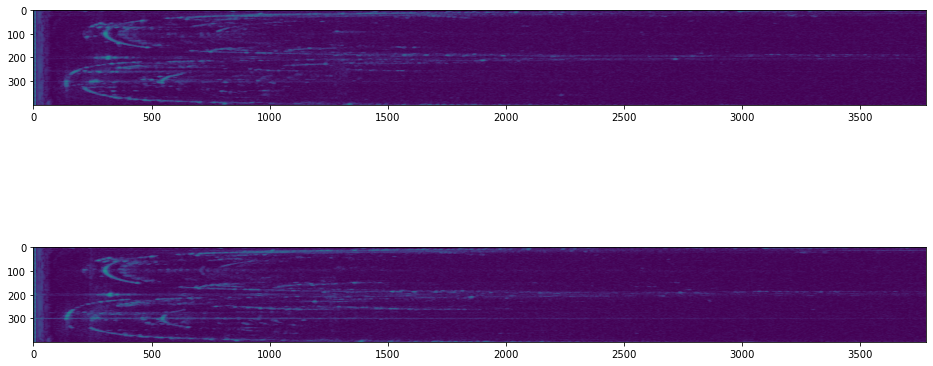

In [29]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.imshow(tgt_im)
plt.subplot(2,1,2)
plt.imshow(src_im)

In [13]:
#tgt = torch.Tensor(np.array(Image.open("000002.png"), dtype=np.float32)).to(device)
#src = torch.Tensor(np.array(Image.open("000001.png"), dtype=np.float32)).to(device)

In [93]:
# bu metadata nın ne işe yaradığı belli değil. gerek yok gibi.
encoder_size = 5600
azimuths = np.array(tgt_im)[:,8:10] / float(encoder_size) * 2 * np.pi
print(azimuths.shape)
print(azimuths)

(400, 2)
[[0.01458597 0.        ]
 [0.03029393 0.        ]
 [0.04600189 0.        ]
 [0.06170986 0.        ]
 [0.07741782 0.        ]
 [0.09312578 0.        ]
 [0.10883375 0.        ]
 [0.12454171 0.        ]
 [0.14024967 0.        ]
 [0.15595764 0.        ]
 [0.1716656  0.        ]
 [0.18737356 0.        ]
 [0.20308153 0.        ]
 [0.21878949 0.        ]
 [0.23449745 0.        ]
 [0.25020541 0.        ]
 [0.26591338 0.        ]
 [0.28162134 0.        ]
 [0.01009798 0.001122  ]
 [0.02580594 0.001122  ]
 [0.0415139  0.001122  ]
 [0.05722187 0.001122  ]
 [0.07292983 0.001122  ]
 [0.08863779 0.001122  ]
 [0.10434576 0.001122  ]
 [0.12005372 0.001122  ]
 [0.13576168 0.001122  ]
 [0.15146965 0.001122  ]
 [0.16717761 0.001122  ]
 [0.18288557 0.001122  ]
 [0.19859354 0.001122  ]
 [0.2143015  0.001122  ]
 [0.23000946 0.001122  ]
 [0.24571743 0.001122  ]
 [0.26142539 0.001122  ]
 [0.27713335 0.001122  ]
 [0.00560999 0.00224399]
 [0.02131795 0.00224399]
 [0.03702591 0.00224399]
 [0.05273388 0.0

In [22]:
tgt = tgt[None,None,11:,:]
src = src[None,None,11:,:]
tgt.shape

torch.Size([1, 1, 3768, 400])

In [11]:
norm_tgt = (tgt-tgt.mean())/tgt.std()
print(norm_tgt.mean())

tensor(6.4605e-09, device='cuda:0')


In [19]:
# rangeResolutionsInMeter = 0.0977 # TI MMwave
rangeResolutionsInMeter = 0.175
#angleResolutionInDeg = 0.9 #deg
angleResolutionInRad = 0.015708
numRangeBins = 3768 # 256-TI, 576-Radiate, 3768-Robotcar
num_angle_bins = 400 # 64-TI



In [ ]:
warper = Warper(rangeResolutionsInMeter, angleResolutionInRad, numRangeBins, num_angle_bins, 0)

In [17]:
b=1
pose = torch.tensor([0., 0, 0, 1.75,0.51,0.])
print(pose.shape)
pose_batch = pose.repeat(b,1)
print(pose_batch.shape)
pose_batch = pose_batch.to(device)

torch.Size([6])
torch.Size([1, 6])


In [18]:
projected_img, valid_points, theta_tformed, rho_tformed = warper.inverse_warp_fft(src, pose_batch)

/home/yasin/anaconda3/envs/pytorch17/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [19]:
img_tgt = tensor2array(tgt[0], colormap='bone')
img_src = tensor2array(projected_img[0], colormap='bone')
img_valid = tensor2array(valid_points[0], colormap='bone', max_value=1)

img_tgt=img_tgt.transpose(1, 2, 0)
img_src=img_src.transpose(1, 2, 0)
img_valid=img_valid.transpose(1, 2, 0)

print(img_tgt.shape)
print(img_src.shape)
print(img_valid.shape)

(576, 400, 4)
(576, 400, 4)
(576, 400, 4)


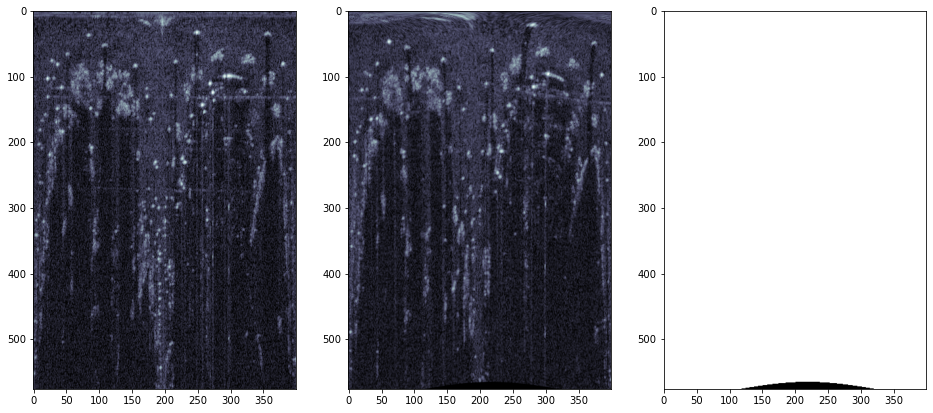

In [20]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(img_tgt)
plt.subplot(132)
plt.imshow(img_src)
plt.subplot(133)
plt.imshow(img_valid)

# Warp code test for 2$\pi$

In [110]:
azimuths = torch.arange(num_angle_bins)
azimuths = (azimuths - (num_angle_bins / 2))
azimuths = azimuths*angleResolutionInRad
ranges = torch.arange(numRangeBins)
ranges = ranges*rangeResolutionsInMeter

az_grid, range_grid = torch.meshgrid(azimuths, ranges) # [num_angle_bins, numRangeBins], i.e. [W, H]
x, y = pol2cart(az_grid, range_grid)
x=torch.flatten(x)
y=torch.flatten(y)

xy = torch.vstack((x, y, torch.zeros_like(x)))  # [3,N] Augment with zero z column
xy = torch.transpose(xy, 0,1) # [N,3]
xy_hom = tgm.convert_points_to_homogeneous(xy).to(device) # [N,4]

In [111]:
x_np = x.cpu().numpy()
y_np = y.cpu().numpy()
c_np = c=tgt.cpu().numpy()
c_np = c_np.flatten()
print(x_np.shape)
print(y_np.shape)
print(c_np.shape)

(1507200,)
(1507200,)
(1507200,)


In [112]:
tgt_np = np.array(tgt_im)
print(tgt_np.shape)

(400, 3779)


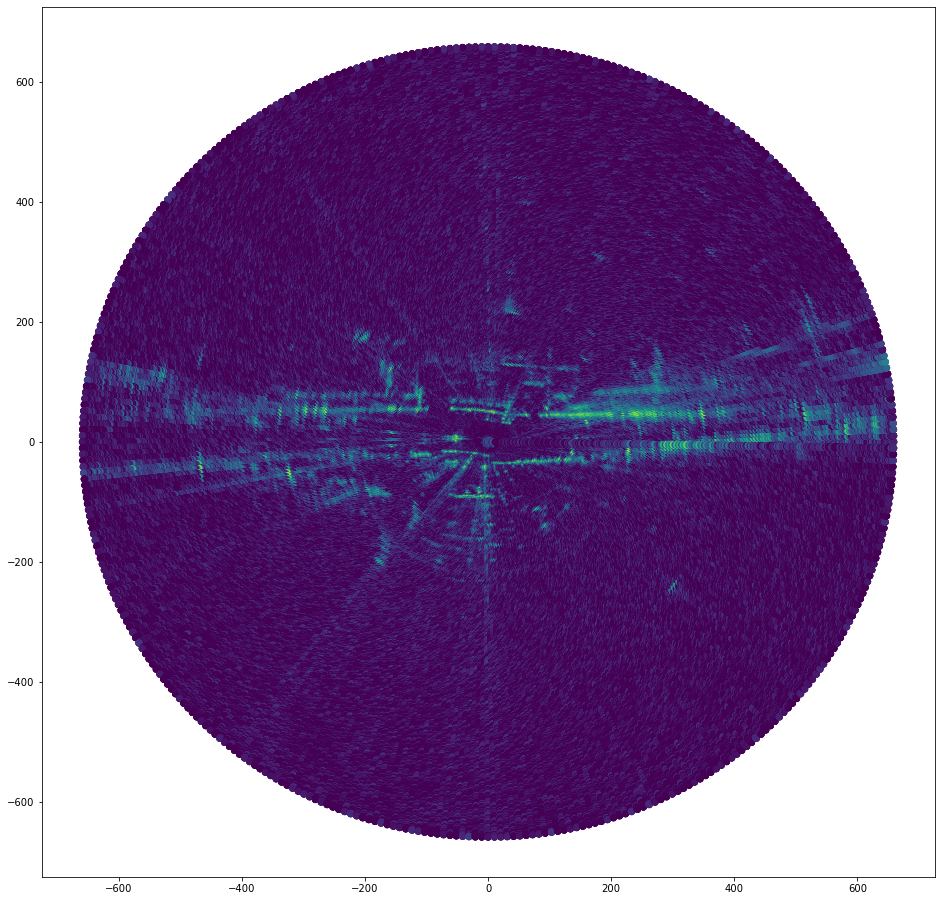

In [105]:
plt.figure(figsize=(16,16))
plt.scatter(x_np, y_np, c=np.array(tgt_im)[:,11:])

In [113]:
pose = torch.tensor([0., 0, 1.57, 150,150,0]) # rx,ry,rz,x,y,z
#pose = torch.tensor([0., 0, 0, 0.1,0,0]) # rx,ry,rz,x,y,z
print(pose.shape)
pose_batch = pose.repeat(1,1)
print(pose_batch.shape)
pose_batch = pose_batch.to(device)

torch.Size([6])
torch.Size([1, 6])


In [114]:
pose = pose_batch
#def inverse_warp_fft(self, img, pose, rotation_mode='euler'):
"""
Inverse warp a source radar frame to the target radar plane.
H: Number of ADC samples (or Doppler bins)
W: Number of angle bins
Args:
    img: the source radar frame image (where to sample pixels) -- [B, H, W]
    pose: 6DoF pose parameters from target to source -- [B, 6]
Returns:
    projected_img: Source image warped to the target image plane
    valid_points: Boolean array indicating point validity
"""

# Convert 6 DoF pose to 4x4 transformation matrix
pose_mat = tgm.rtvec_to_pose(pose)  # T*R in homogenous coordinates [B,4,4]



In [115]:
#def radar2pixel(self, pose_mat):
"""Transform coordinates in the source frame to the target frame.
Args:
    cam_coords: pixel coordinates defined in the first camera coordinates system -- [B, 4, H, W]
    proj_c2p_rot: rotation matrix of cameras -- [B, 3, 4]
    proj_c2p_tr: translation vectors of cameras -- [B, 3, 1]
Returns:
    array of [-1,1] coordinates -- [B, 2, H, W]
"""
# Transform points
tformed_xy_hom = torch.matmul(pose_mat, torch.transpose(xy_hom, 0,1)) # [B,4,N]
tformed_xy_hom = torch.transpose(tformed_xy_hom, 1,2) # [B,N,4]
# Convert from homogenous coordinates
tformed_xy = tgm.convert_points_from_homogeneous(tformed_xy_hom) # [B,N,3]
# Convert back from cartesian to polar
theta_tformed_rad, rho_tformed = cart2pol(tformed_xy[:,:,0], tformed_xy[:,:,1]) # [B,N], [B,N]
# theta_tformed = torch.rad2deg(theta_tformed_rad) # [B,N]

# tformed_xy = tformed_xy[:,0:2,:] # Drop augmented z column [B,2,N]
# Replace 0-valued augmented z column with dB values of source img 
# tformed_xy[:,2,:] = torch.flatten(img, start_dim=1) # [B,3,N] N points with x,y and db values



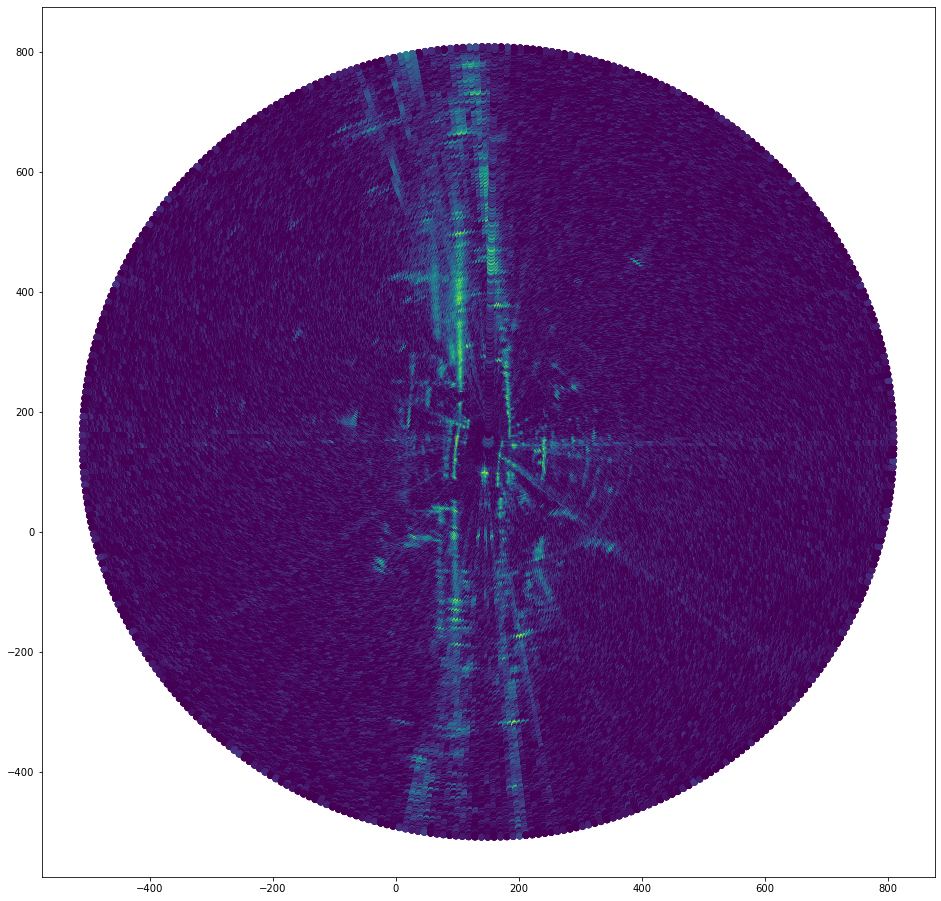

In [109]:
plt.figure(figsize=(16,16))
plt.scatter(tformed_xy[:,:,0].cpu(), tformed_xy[:,:,1].cpu(), c=np.array(tgt_im)[:,11:])

In [116]:
X = theta_tformed_rad #theta_tformed # [B,N]
Y = rho_tformed # [B,N]
w = num_angle_bins*angleResolutionInRad
h = numRangeBins*rangeResolutionsInMeter

# Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
X_norm = 2*X/w
Y_norm = 2*Y/h - 1  # Idem [B, H*W]



In [117]:
print(X.min(), X.max())
print(X_norm.min(), X_norm.max())

tensor(-3.1416, device='cuda:0') tensor(3.1416, device='cuda:0')
tensor(-1.0000, device='cuda:0') tensor(1.0000, device='cuda:0')


In [118]:
print(Y.min(), Y.max())
print(Y_norm.min(), Y_norm.max())

tensor(0.1708, device='cuda:0') tensor(871.3566, device='cuda:0')
tensor(-0.9995, device='cuda:0') tensor(1.6429, device='cuda:0')


In [ ]:
pixel_coords = torch.stack([X_norm, Y_norm], dim=2)  # [B, H*W, 2]
pixel_coords = pixel_coords.reshape(self.b, self.w, self.h, 2) # [B, W, H, 2]
pixel_coords = pixel_coords.transpose(1,2) # [B, H, W, 2]

#return pixel_coords, theta_tformed, rho_tformed

In [ ]:
# src_pixel_coords = pixel_coords.reshape(b, h, w, 2)
src_pixel_coords, theta_tformed, rho_tformed = self.radar2pixel(pose_mat)  # [B,H,W,2]

projected_img = F.grid_sample(
    img, src_pixel_coords, padding_mode=self.padding_mode)

# calculate mask values for each tformed_xy coordinates to match the target xy
valid_points = src_pixel_coords.abs().max(dim=-1)[0] <= 1 # [B,H,W]
valid_points = torch.unsqueeze(valid_points, 1) # [B,1,H,W]

#return projected_img, valid_points, theta_tformed, rho_tformed

# Test SSIM

In [33]:
ssim_value = ssim(tgt, src, valid_points)
print(ssim_value)

tensor(0.0641, device='cuda:0')


In [30]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, mask, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    
    ssim_map = ssim_map*mask

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2, mask):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, mask, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, mask, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, mask, window, window_size, channel, size_average)